In [1]:
from google.cloud import bigquery
import operator
import networkx as nx
from nltk.util import ngrams
from nltk import FreqDist
import matplotlib.pyplot as plt

In [2]:
G = nx.Graph()
client = bigquery.Client.from_service_account_json(
        'My Project-c23185ac100b.json')
client.project

'hardy-moon-199316'

In [3]:
query_word = "operating-system"

In [4]:
query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a
        limit 100000
        """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()

bigrams = []
gram = 2
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)
print(fdist.most_common(30))
associated_words = []
for comb in fdist.most_common(30):
    if query_word in comb[0]:
        associated_words.append(comb[0][comb[0].index(query_word) - 1])
        

[(('linux', 'operating-system'), 514), (('c', 'operating-system'), 490), (('operating-system', 'kernel'), 459), (('process', 'operating-system'), 432), (('c', 'linux'), 340), (('assembly', 'operating-system'), 335), (('memory-management', 'operating-system'), 328), (('multithreading', 'operating-system'), 312), (('linux-kernel', 'operating-system'), 286), (('unix', 'operating-system'), 264), (('windows', 'operating-system'), 248), (('python', 'operating-system'), 244), (('c++', 'c'), 158), (('macos', 'operating-system'), 155), (('operating-system', 'filesystems'), 154), (('memory', 'operating-system'), 151), (('operating-system', 'fork'), 141), (('operating-system', 'paging'), 131), (('java', 'operating-system'), 129), (('c++', 'operating-system'), 127), (('x86', 'operating-system'), 126), (('operating-system', 'scheduling'), 116), (('operating-system', 'system-calls'), 113), (('operating-system', 'x86'), 112), (('linux', 'unix'), 110), (('linux', 'linux-kernel'), 104), (('file', 'oper

In [5]:
associated_words


['linux',
 'c',
 'kernel',
 'process',
 'assembly',
 'memory-management',
 'multithreading',
 'linux-kernel',
 'unix',
 'windows',
 'python',
 'macos',
 'filesystems',
 'memory',
 'fork',
 'paging',
 'java',
 'c++',
 'x86',
 'scheduling',
 'system-calls',
 'x86',
 'file',
 'android',
 'virtual-memory']

In [6]:
correlation = []
for word in associated_words:
    query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a
        limit 100000
        """
    query_params = [
        bigquery.ScalarQueryParameter(
            'a', 'STRING', "%"+word+"%")
        ]
    job_config = bigquery.QueryJobConfig()
    job_config.query_parameters = query_params
    query_job = client.query(query, job_config=job_config)
    results = query_job.result()
    bigrams = []
    gram = 2
    for row in results:
        token = row.tags.split('|')
        bigram = list(ngrams(token,gram))
        bigrams.extend(bigram)
    fdist=FreqDist(bigrams)
    strong_words_temp = []
    
    for comb in fdist.most_common(20):
        if word in comb[0]:
            strong_words_temp.append(comb[0][comb[0].index(word) - 1]) 
            if comb[0][comb[0].index(word) - 1]  == query_word or (word != comb[0][comb[0].index(word) - 1]) and comb[0][comb[0].index(word) - 1] in strong_words:
                correlation.append(word)
    print(word, strong_words_temp)
print(correlation)

NameError: name 'strong_words' is not defined

In [ ]:
set(correlation)

In [ ]:
# take these strong words and then use the with initial word and use them together to find one bigger ngram.
most_frequent_3_comb = {}
for word in set(correlation):
    query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a and tags like @b
        limit 1000000
        """
    query_params = [
        bigquery.ScalarQueryParameter(
            'a', 'STRING', "%"+word+"%"),
        bigquery.ScalarQueryParameter(
            'b', 'STRING', "%"+query_word+"%")
        ]
    job_config = bigquery.QueryJobConfig()
    job_config.query_parameters = query_params
    query_job = client.query(query, job_config=job_config)
    results = query_job.result()
    bigrams = []
    gram = 3
    for row in results:
        token = row.tags.split('|')
        bigram = list(ngrams(token,gram))
        bigrams.extend(bigram)
    fdist=FreqDist(bigrams)
    
    for l in fdist.most_common(5):
        for w in l[0]:
            if w not in set(correlation):
                break
            if w in most_frequent_3_comb:
                most_frequent_3_comb[w] += 1
            else:
                most_frequent_3_comb[w] = 1
print(most_frequent_3_comb)
    

In [ ]:
most_frequent_comb = sorted(most_frequent_3_comb.items(), key=operator.itemgetter(1), reverse=True)[0][0]

In [ ]:
most_frequent_comb

In [ ]:
# i can obviosuly go directly but then that would not be the right way to navigate to that tag. I have to find what is the
# right link to get to that word that actually makes sense. for example data structure, tree, binary-search-tree would be 
# right link rather than data structure, java, binary-search-tree

# I can get to binary search tree faster thru tree than going thru graph. 

In [ ]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b
    limit 1000000
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()
bigrams = []
gram = 3
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)

In [ ]:
fdist.most_common(10)
# what if all of them have the same score and some of them contains both the words then which word do you choose? 

In [ ]:
other_comb_word = [x for x in fdist.most_common(5)[0][0] if x not in [most_frequent_comb, query_word]][0]
other_comb_word

In [ ]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b and tags like @c
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+other_comb_word+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'c', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()
bigrams = []
gram = 4
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)

In [ ]:
fdist.most_common(5)

In [ ]:
query = """
    SELECT title, score
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b and tags like @c
    order by score desc
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+other_comb_word+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'c', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [ ]:
results = query_job.result()
for row in results:
    print(row.title, row.score)

In [ ]:
query = """
    SELECT tags, title
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a 
    order by score desc
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [7]:
results = query_job.result()
for row in results:
    print(row.tags, row.title)

AttributeError: no row field 'title'

In [8]:
# there are many ways to miss the most important questions just because there was no tag associated with it. 
# This way I might miss many of the important questions on 2-3-4 trees. 

In [9]:
query = """
    SELECT tag_name, count
    FROM `bigquery-public-data.stackoverflow.tags`
    where tag_name like "%data-structure%"
    """
nfig = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [10]:
results = query_job.result()


In [11]:
for row in results:
    print(row.tag_name, row.count)

perl-data-structures 397
data-structures 20723


In [12]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    """
nfig = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [13]:
import numpy as np
results = query_job.result()
import csv

with open('data.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    for row in results:
        wr.writerow(row.tags.split("|"))

KeyboardInterrupt: 

In [ ]:
1576162/45992355

In [14]:
results = query_job.result()
m = 0
for row in results:
    if (row.tags.count("|")) > m:
        m = row.tags.count("|")

KeyboardInterrupt: 

In [ ]:
m

In [3]:
import csv 
import sys #used for passing in the argument
file_name = "data.csv" #filename is argument 1
with open(file_name, 'rU') as f:  #opens PW file
    reader = csv.reader(f)
    data = list(list(rec) for rec in csv.reader(f, delimiter=',')) #reads csv into a list of lists


/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.


In [16]:
len(data)

15483377

In [1]:
from gensim.models import Word2Vec

In [2]:
b = Word2Vec(data, min_count=1000, size=200)

NameError: name 'data' is not defined

In [19]:
b.most_similar([ '2-3-4'], topn=20)

/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


KeyError: "word '2-3-4' not in vocabulary"

In [1355]:
X = b[b.wv.vocab]

/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [1356]:
X

array([[-0.0861189 ,  0.34867617, -0.62697285, ...,  0.14198647,
        -1.018337  ,  0.9163711 ],
       [ 0.38093942,  0.19360177, -0.551457  , ..., -0.8138982 ,
        -0.06398335,  0.15266758],
       [-2.2275815 ,  0.54211175, -0.46061146, ..., -0.351588  ,
        -0.1419729 ,  1.4605063 ],
       ...,
       [-0.6491097 ,  1.0211784 , -0.24942423, ..., -0.02212717,
         0.26639113, -0.9794805 ],
       [ 0.33427015, -0.07120291,  0.51148254, ..., -0.01063465,
         0.33203802, -0.09599789],
       [-0.15773684,  0.3832577 , -0.0436539 , ..., -0.7603381 ,
         0.1659639 ,  0.30151373]], dtype=float32)

In [1424]:
from nltk.cluster import KMeansClusterer
import nltk
NUM_CLUSTERS=3
kclusterer = KMeansClusterer(100, distance=nltk.cluster.util.cosine_distance)

In [1434]:
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
print (assigned_clusters)

TypeError: Cannot cast array data from dtype('float32') to dtype('<U32') according to the rule 'safe'

In [1435]:
words = list(b.wv.vocab)
word_cluster = {}
for i, word in enumerate(words):  
    word_cluster[word] = assigned_clusters[i]
    print (word + ":" + str(assigned_clusters[i]))


asp.net:96
code-behind:19
javascript:15
ajax:15
c++:18
linux:67
php:6
mysql:37
jquery:15
html:65
css3:49
css-animations:49
angularjs:1
angular:1
protractor:40
python:64
pandas:39
cython:64
highcharts:59
highstock:59
java:43
treeview:19
javafx-2:93
c#:19
c#-4.0:19
silverlight-4.0:33
foreach:50
excel:11
multithreading:46
perl:35
zend-framework:6
lucene:16
objective-c:30
cocoa:30
imap:89
ssl:89
arrays:5
listview:61
titanium:32
underscore.js:72
meteor:58
iron-router:72
sql:20
visual-studio-2008:26
reporting-services:44
where:20
ios:23
animation:70
logging:52
logback:24
javascript-events:0
.net:19
asp.net-web-api:96
qt:99
asp.net-mvc:96
entity-framework:85
flex:21
flash:21
adobe:21
flash-builder:21
dom:0
cocoa-touch:30
grand-central-dispatch:30
uitableview:23
label:95
bash:28
sed:28
exec:79
android:61
math:5
gps:60
signals:79
xcode:30
swift:23
scroll:70
maven:24
jenkins:69
continuous-integration:69
hudson:69
css:49
matlab:35
machine-learning:88
neural-network:88
artificial-intelligence:88
o

weka:88
data-mining:88
android-drawable:61
delete-row:20
c#-2.0:19
facebook-like:65
64bit:63
focus:70
sql-insert:37
unobtrusive-validation:15
pascal:35
segue:23
nsdate:3
credit-card:90
saxon:42
twilio:90
matlab-figure:92
infinite-loop:68
regression:88
criteria:20
implementation:14
ui-automation:40
folder:38
uiviewanimation:77
karma-jasmine:1
m2eclipse:24
var:50
scrolltop:0
scheduler:46
quartz-scheduler:87
jobs:46
iis-7.5:57
marionette:72
blockchain:10
kendo-asp.net-mvc:15
libcurl:34
marshalling:73
nsxmlparser:30
subsonic:85
repeat:95
amazon-sns:10
lift:83
sublimetext3:25
code-signing:63
ipa:30
viewport:49
laravel-5.3:6
openlayers:59
opencl:34
feed:78
nservicebus:2
google-cloud-datastore:16
composition:14
observer-pattern:14
key-value-observing:23
reverse:17
background-image:49
pseudo-element:49
google-cloud-functions:56
storyboard:23
landscape:70
entity-framework-core:85
terminology:35
jquery-ui-sortable:15
macos-sierra:67
clang:34
andengine:61
directive:1
watch:91
parameter-passing:50

uitoolbar:23
latitude-longitude:60
tastypie:12
swipe:70
restful-authentication:12
chromecast:98
service-worker:76
innodb:37
detection:97
schema.org:65
game-center:30
quickbooks:90
sql-server-express:44
pyramid:64
videoview:61
instruments:30
icalendar:3
cakephp-2.1:6
live-streaming:98
using:73
z3:45
bufferedreader:71
ontouchlistener:61
scp:67
google-compute-engine:55
porting:34
database-replication:37
filemaker:37
esp8266:36
itertools:17
delayed-job:47
kettle:27
na:39
bookmarklet:76
circle:97
scons:34
barcode:29
division:5
sugarcrm:22
bayesian:88
w3c:76
aws-cli:10
fwrite:82
angularfire:1
webfonts:76
bitcoin:90
paintcomponent:93
scrapy-spider:64
angular2-directives:1
raspberry-pi2:36
inputstream:71
openldap:55
paste:95
horizontal-scrolling:49
ctypes:64
appstore-approval:30
numeric:5
android-resources:61
logcat:54
tcp-ip:89
decoding:7
dto:85
monitor:79
glfw:34
overlap:49
text-editor:25
member:50
allocation:81
bottle:64
epplus:11
elf:34
rethinkdb:16
android-alarms:84
django-queryset:20
rea

In [1436]:
word_cluster

{'asp.net': 96,
 'code-behind': 19,
 'javascript': 15,
 'ajax': 15,
 'c++': 18,
 'linux': 67,
 'php': 6,
 'mysql': 37,
 'jquery': 15,
 'html': 65,
 'css3': 49,
 'css-animations': 49,
 'angularjs': 1,
 'angular': 1,
 'protractor': 40,
 'python': 64,
 'pandas': 39,
 'cython': 64,
 'highcharts': 59,
 'highstock': 59,
 'java': 43,
 'treeview': 19,
 'javafx-2': 93,
 'c#': 19,
 'c#-4.0': 19,
 'silverlight-4.0': 33,
 'foreach': 50,
 'excel': 11,
 'multithreading': 46,
 'perl': 35,
 'zend-framework': 6,
 'lucene': 16,
 'objective-c': 30,
 'cocoa': 30,
 'imap': 89,
 'ssl': 89,
 'arrays': 5,
 'listview': 61,
 'titanium': 32,
 'underscore.js': 72,
 'meteor': 58,
 'iron-router': 72,
 'sql': 20,
 'visual-studio-2008': 26,
 'reporting-services': 44,
 'where': 20,
 'ios': 23,
 'animation': 70,
 'logging': 52,
 'logback': 24,
 'javascript-events': 0,
 '.net': 19,
 'asp.net-web-api': 96,
 'qt': 99,
 'asp.net-mvc': 96,
 'entity-framework': 85,
 'flex': 21,
 'flash': 21,
 'adobe': 21,
 'flash-builder': 2

In [1437]:
from collections import defaultdict

v = defaultdict(list)

for key, value in sorted(word_cluster.items()):
    v[value].append(key)

In [1438]:
v

defaultdict(list,
            {0: ['accordion',
              'addclass',
              'addeventlistener',
              'alert',
              'attr',
              'children',
              'click',
              'colorbox',
              'conflict',
              'contenteditable',
              'cycle',
              'dom',
              'draggable',
              'each',
              'element',
              'fade',
              'fadein',
              'fadeout',
              'fancybox',
              'fancybox-2',
              'flexslider',
              'gallery',
              'getelementbyid',
              'hidden',
              'hide',
              'image-gallery',
              'innerhtml',
              'javascript-events',
              'jquery-animate',
              'jquery-selectors',
              'jsfiddle',
              'lightbox',
              'live',
              'load',
              'modal-dialog',
              'mootools',
              'mouseover',
 

In [1410]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
 

# generate the linkage matrix
Z = linkage(X, 'ward')


In [1412]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.2384684021301623

In [1381]:
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',

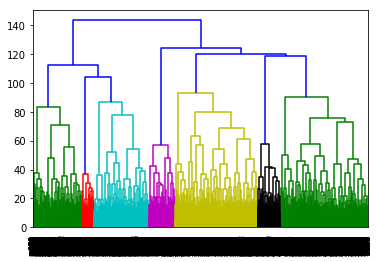

In [1382]:
plt.show()

array([996.        , 997.        ,   2.15974402,   2.        ])

In [1428]:
b.wv.

{'asp.net': <gensim.models.keyedvectors.Vocab at 0x24c50cb70>,
 'code-behind': <gensim.models.keyedvectors.Vocab at 0x24c50cbe0>,
 'javascript': <gensim.models.keyedvectors.Vocab at 0x24c50cc18>,
 'ajax': <gensim.models.keyedvectors.Vocab at 0x24c50cba8>,
 'c++': <gensim.models.keyedvectors.Vocab at 0x24c50c7b8>,
 'linux': <gensim.models.keyedvectors.Vocab at 0x24c50c748>,
 'php': <gensim.models.keyedvectors.Vocab at 0x24c50c6a0>,
 'mysql': <gensim.models.keyedvectors.Vocab at 0x24c50c7f0>,
 'jquery': <gensim.models.keyedvectors.Vocab at 0x24c50cc50>,
 'html': <gensim.models.keyedvectors.Vocab at 0x24c50cc88>,
 'css3': <gensim.models.keyedvectors.Vocab at 0x24c50ccc0>,
 'css-animations': <gensim.models.keyedvectors.Vocab at 0x24c50ccf8>,
 'angularjs': <gensim.models.keyedvectors.Vocab at 0x24c50cd30>,
 'angular': <gensim.models.keyedvectors.Vocab at 0x24c50cd68>,
 'protractor': <gensim.models.keyedvectors.Vocab at 0x24c50cda0>,
 'python': <gensim.models.keyedvectors.Vocab at 0x24c50cdd

In [1427]:
len(Z)

3978

In [1418]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

NameError: name 'fancy_dendrogram' is not defined

In [1419]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

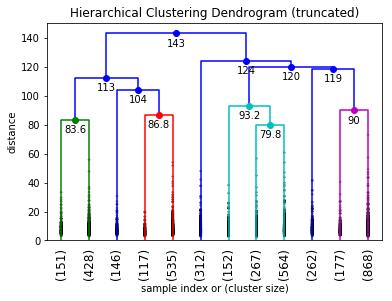

In [1420]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

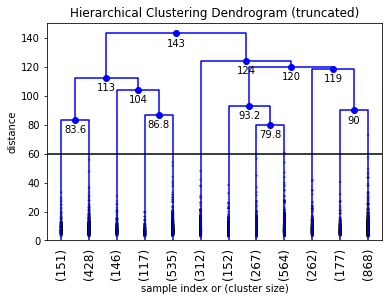

In [1421]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=60,  # plot a horizontal cut-off line
)
plt.show()

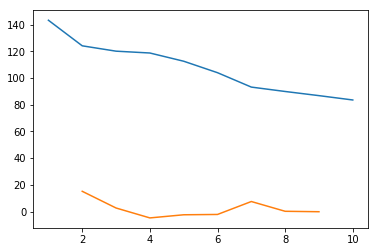

clusters: 2


In [1423]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print( "clusters:", k)

In [ ]:
#as the reputation increases, find out the tags of the questions being asked by these users. Also find out the answers
# frequency with which they ask question and answer. and what is the general trend of the scores of these answers. 
# is there a trend that we see? So that we can use thes trend and then predict what type of questions to show to the user. 
# for him to answer. Or just read with the answer of these questions. 